In [1]:
import imblearn
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox

In [2]:
df = pd.read_csv("contributors2.csv")
selected_columns = ['name_with_owner','is_core', 'repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio']

# Subset the DataFrame based on the selected columns
c3 = df[selected_columns].copy()
#get projects not in cluster
c3_cols = ['umijs/umi', 'netbox-community/netbox', 'grafana/loki', 'awsdocs/aws-doc-sdk-examples', 'vueuse/vueuse',
     'yuzu-emu/yuzu', 'TanStack/query', 'lvgl/lvgl', 'arendst/Tasmota', 'Aircoookie/WLED']
#combine into one list
c3 = c3[c3['name_with_owner'].isin(c3_cols)]
c3 = c3.drop(columns = 'name_with_owner')

In [3]:
c3

,is_core,repos,gists,followers,following,months_experience,has_bio
5,0,151,6,235,36,125.65,1
8,0,55,0,21,3,130.54,0
10,0,136,3,9,19,70.95,1
11,0,548,19,1707,5,108.31,0
12,0,160,8,331,16,122.33,0
...,...,...,...,...,...,...,...
4169,0,41,1,12,36,89.93,1
4170,0,52,0,0,0,15.04,0
4628,0,166,6,24,69,122.94,1
6582,0,38,1,5,7,139.38,0


In [4]:
X = c3.drop(columns = 'is_core')
y = c3['is_core']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [5]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [6]:
train_df

,repos,gists,followers,following,months_experience,has_bio,is_core
3336,28,0,1,0,51.04,0,0
3913,29,3,39,17,154.54,1,0
1267,51,0,276,0,144.57,0,0
2657,20,0,4,8,92.56,0,0
2147,56,31,59,23,85.66,1,0
...,...,...,...,...,...,...,...
937,1,0,0,0,21.36,0,0
3646,118,32,62,1,168.33,1,0
1928,8,0,13,6,156.57,1,0
2960,185,100,63,58,155.64,0,0


In [7]:
print(train_df['is_core'].value_counts())
print(test_df['is_core'].value_counts())

0    2846
1      71
Name: is_core, dtype: int64
0    718
1     12
Name: is_core, dtype: int64


In [8]:
adasyn = imblearn.over_sampling.ADASYN(random_state = 0)
x_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)
c3_train = pd.DataFrame(data=x_resampled_adasyn, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio'])  # Replace column names as needed
c3_train['is_core'] = y_resampled_adasyn  # Assuming 'target' is the name of your target column
c3_train['has_bio'] = c3_train['has_bio'].apply(lambda x: 1 if x >= 0.5 else 0)
c3_train

,repos,gists,followers,following,months_experience,has_bio,is_core
0,28,0,1,0,51.040000,0,0
1,29,3,39,17,154.540000,1,0
2,51,0,276,0,144.570000,0,0
3,20,0,4,8,92.560000,0,0
4,56,31,59,23,85.660000,1,0
...,...,...,...,...,...,...,...
5668,37,2,451,27,67.126912,1,1
5669,38,2,458,39,76.072258,1,1
5670,126,0,294,23,90.733046,0,1
5671,20,52,474,26,118.308642,1,1


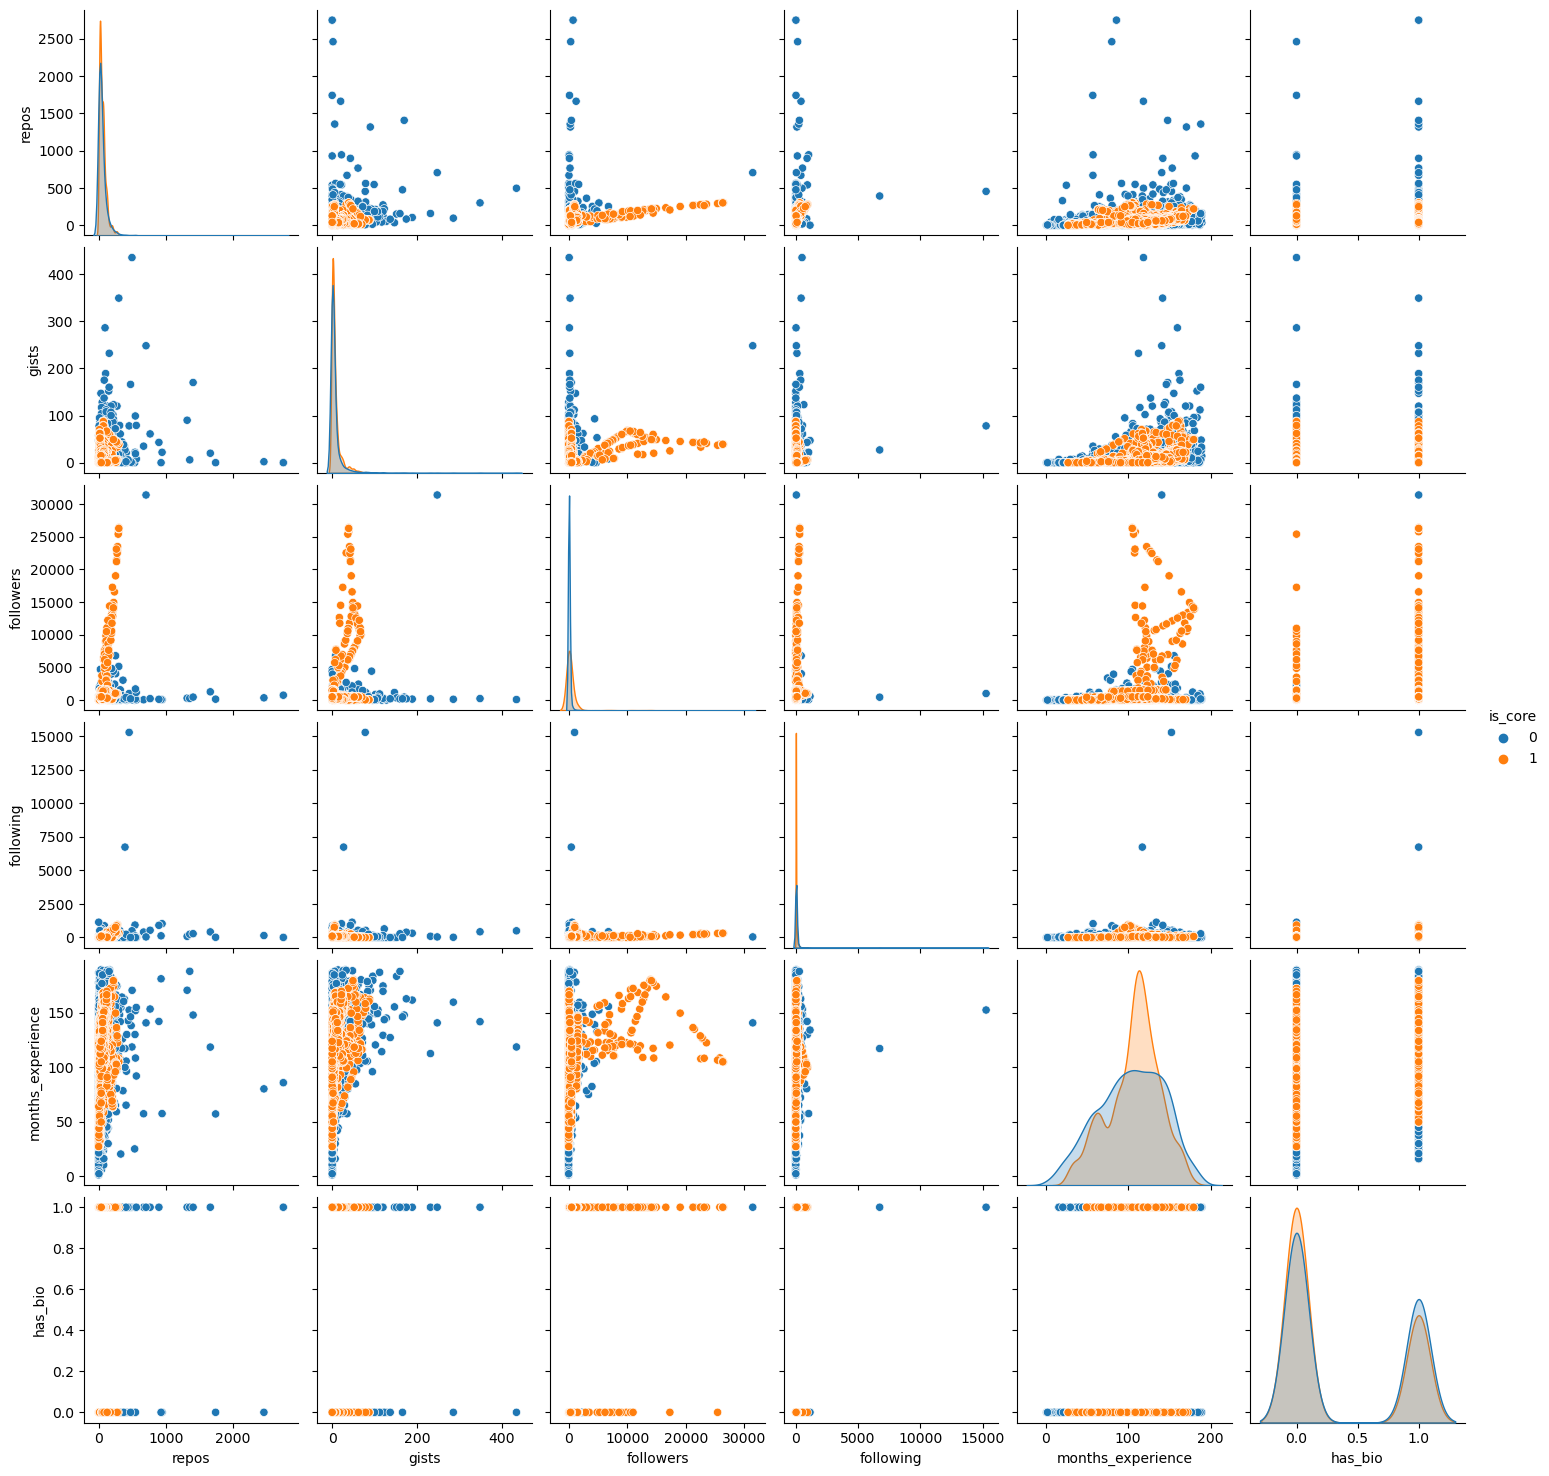

In [9]:
sns.pairplot(c3_train, hue = 'is_core')

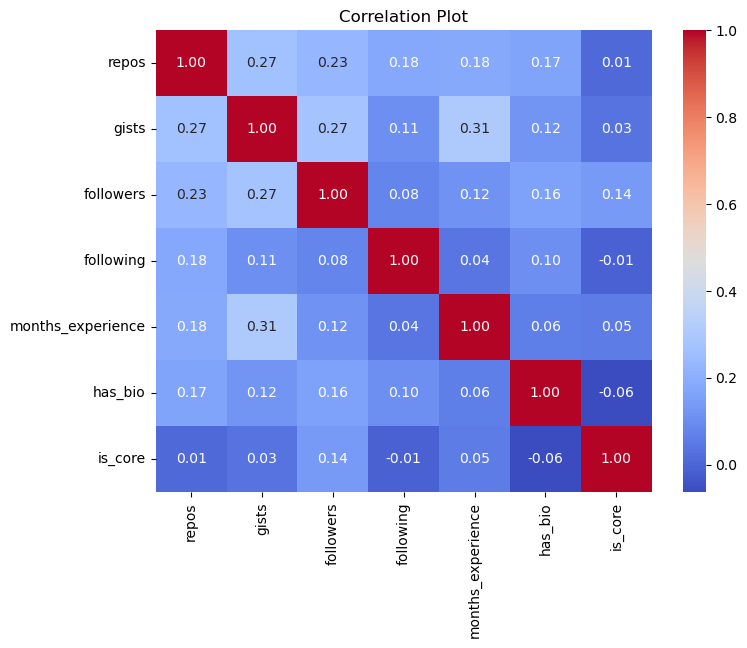

In [10]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c3_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

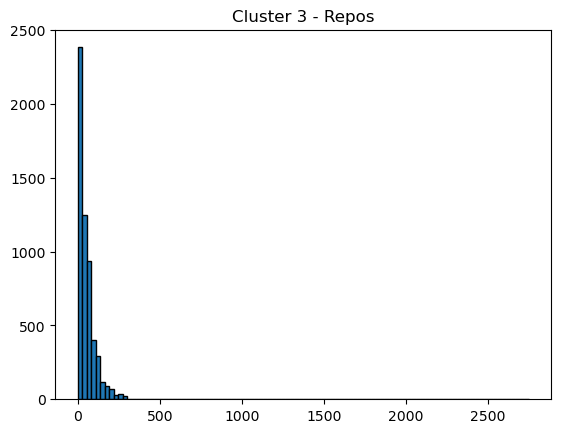

In [11]:
plt.hist(c3_train.repos, bins=100, edgecolor='black')
plt.title('Cluster 3 - Repos')
plt.show()

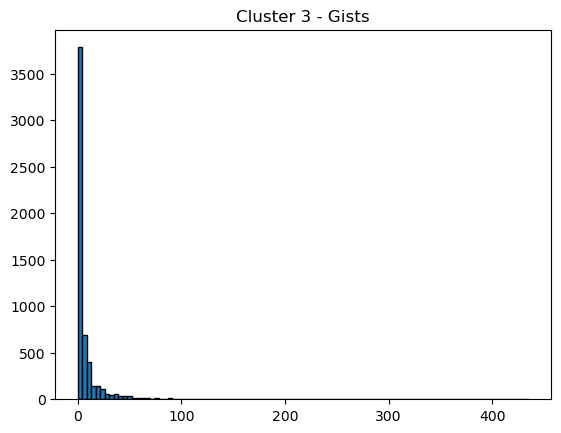

In [12]:
plt.hist(c3_train.gists, bins=100, edgecolor='black')
plt.title('Cluster 3 - Gists')
plt.show()

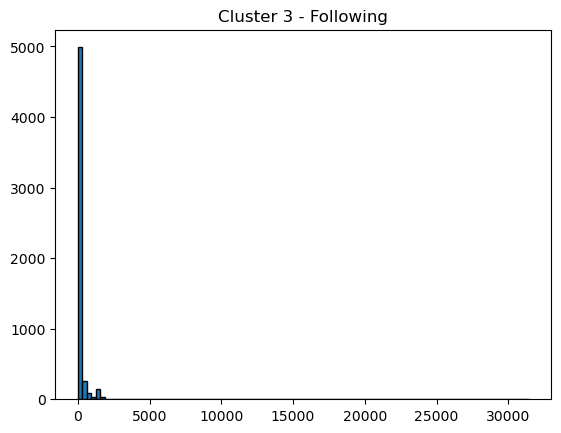

In [13]:
plt.hist(c3_train.followers, bins=100, edgecolor='black')
plt.title('Cluster 3 - Following')
plt.show()

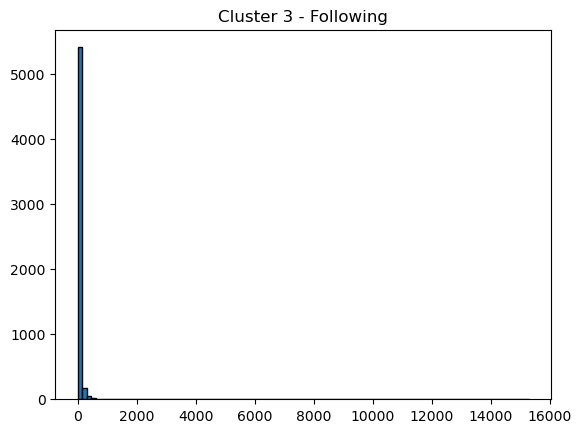

In [14]:
plt.hist(c3_train.following, bins=100, edgecolor='black')
plt.title('Cluster 3 - Following')
plt.show()

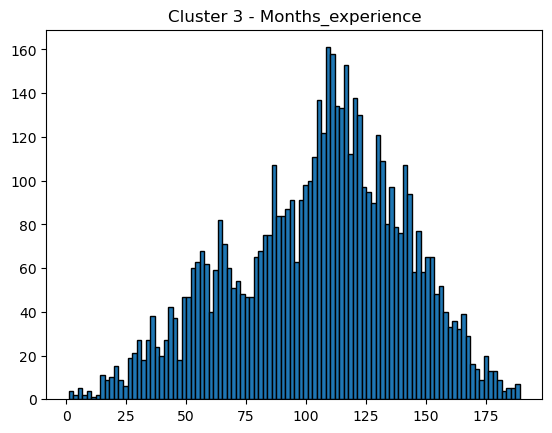

In [15]:
plt.hist(c3_train.months_experience, bins=100, edgecolor='black')
plt.title('Cluster 3 - Months_experience')
plt.show()

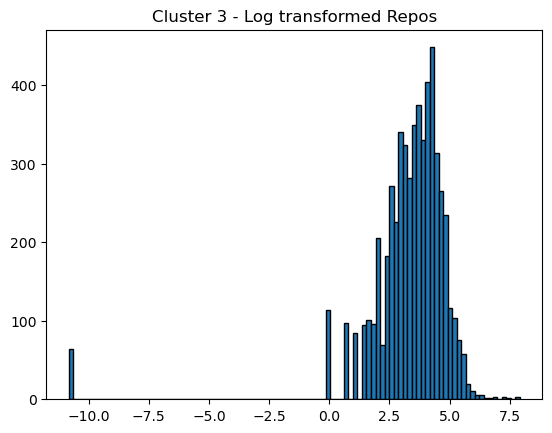

In [16]:
plt.hist(np.log(c3_train.repos+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Repos')
plt.show()

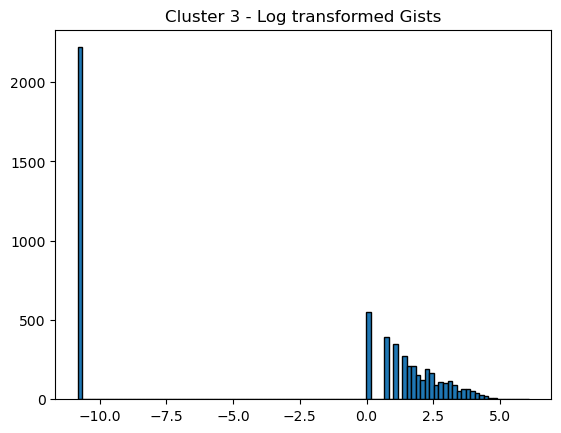

In [17]:
plt.hist(np.log(c3_train.gists+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Gists')
plt.show()

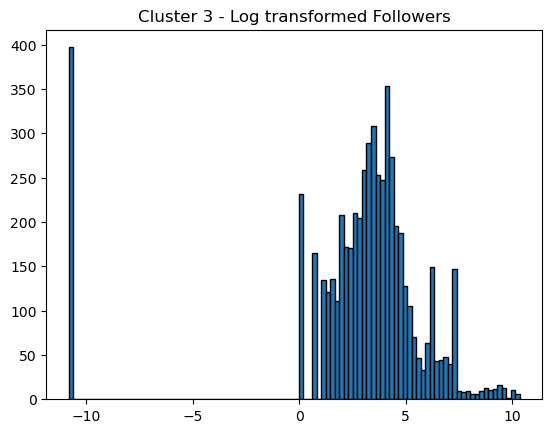

In [18]:
plt.hist(np.log(c3_train.followers+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Followers')
plt.show()

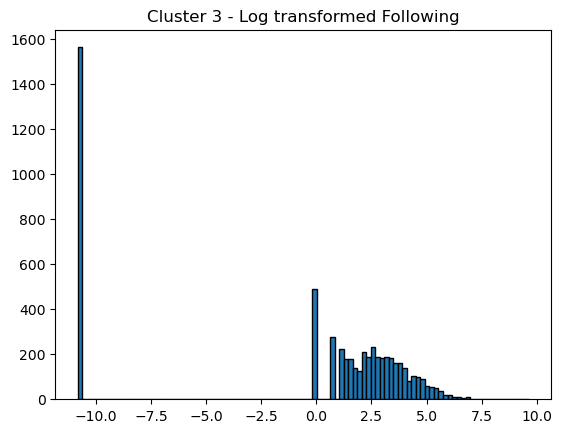

In [19]:
plt.hist(np.log(c3_train.following+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Following')
plt.show()

In [20]:
c3_train_log = c3_train.copy()
c3_train_log['repos'] = np.log(c3_train_log.repos+2e-5)
c3_train_log['gists'] = np.log(c3_train_log.gists+2e-5)
c3_train_log['followers'] = np.log(c3_train_log.followers+2e-5)
c3_train_log['following'] = np.log(c3_train_log.following+2e-5)
c3_train_log

,repos,gists,followers,following,months_experience,has_bio,is_core
0,3.332205,-10.819778,0.000020,-10.819778,51.040000,0,0
1,3.367297,1.098619,3.663562,2.833215,154.540000,1,0
2,3.931826,-10.819778,5.620401,-10.819778,144.570000,0,0
3,2.995733,-10.819778,1.386299,2.079444,92.560000,0,0
4,4.025352,3.433988,4.077538,3.135495,85.660000,1,0
...,...,...,...,...,...,...,...
5668,3.610918,0.693157,6.111467,3.295838,67.126912,1,1
5669,3.637587,0.693157,6.126869,3.663562,76.072258,1,1
5670,4.836282,-10.819778,5.683580,3.135495,90.733046,0,1
5671,2.995733,3.951244,6.161207,3.258097,118.308642,1,1


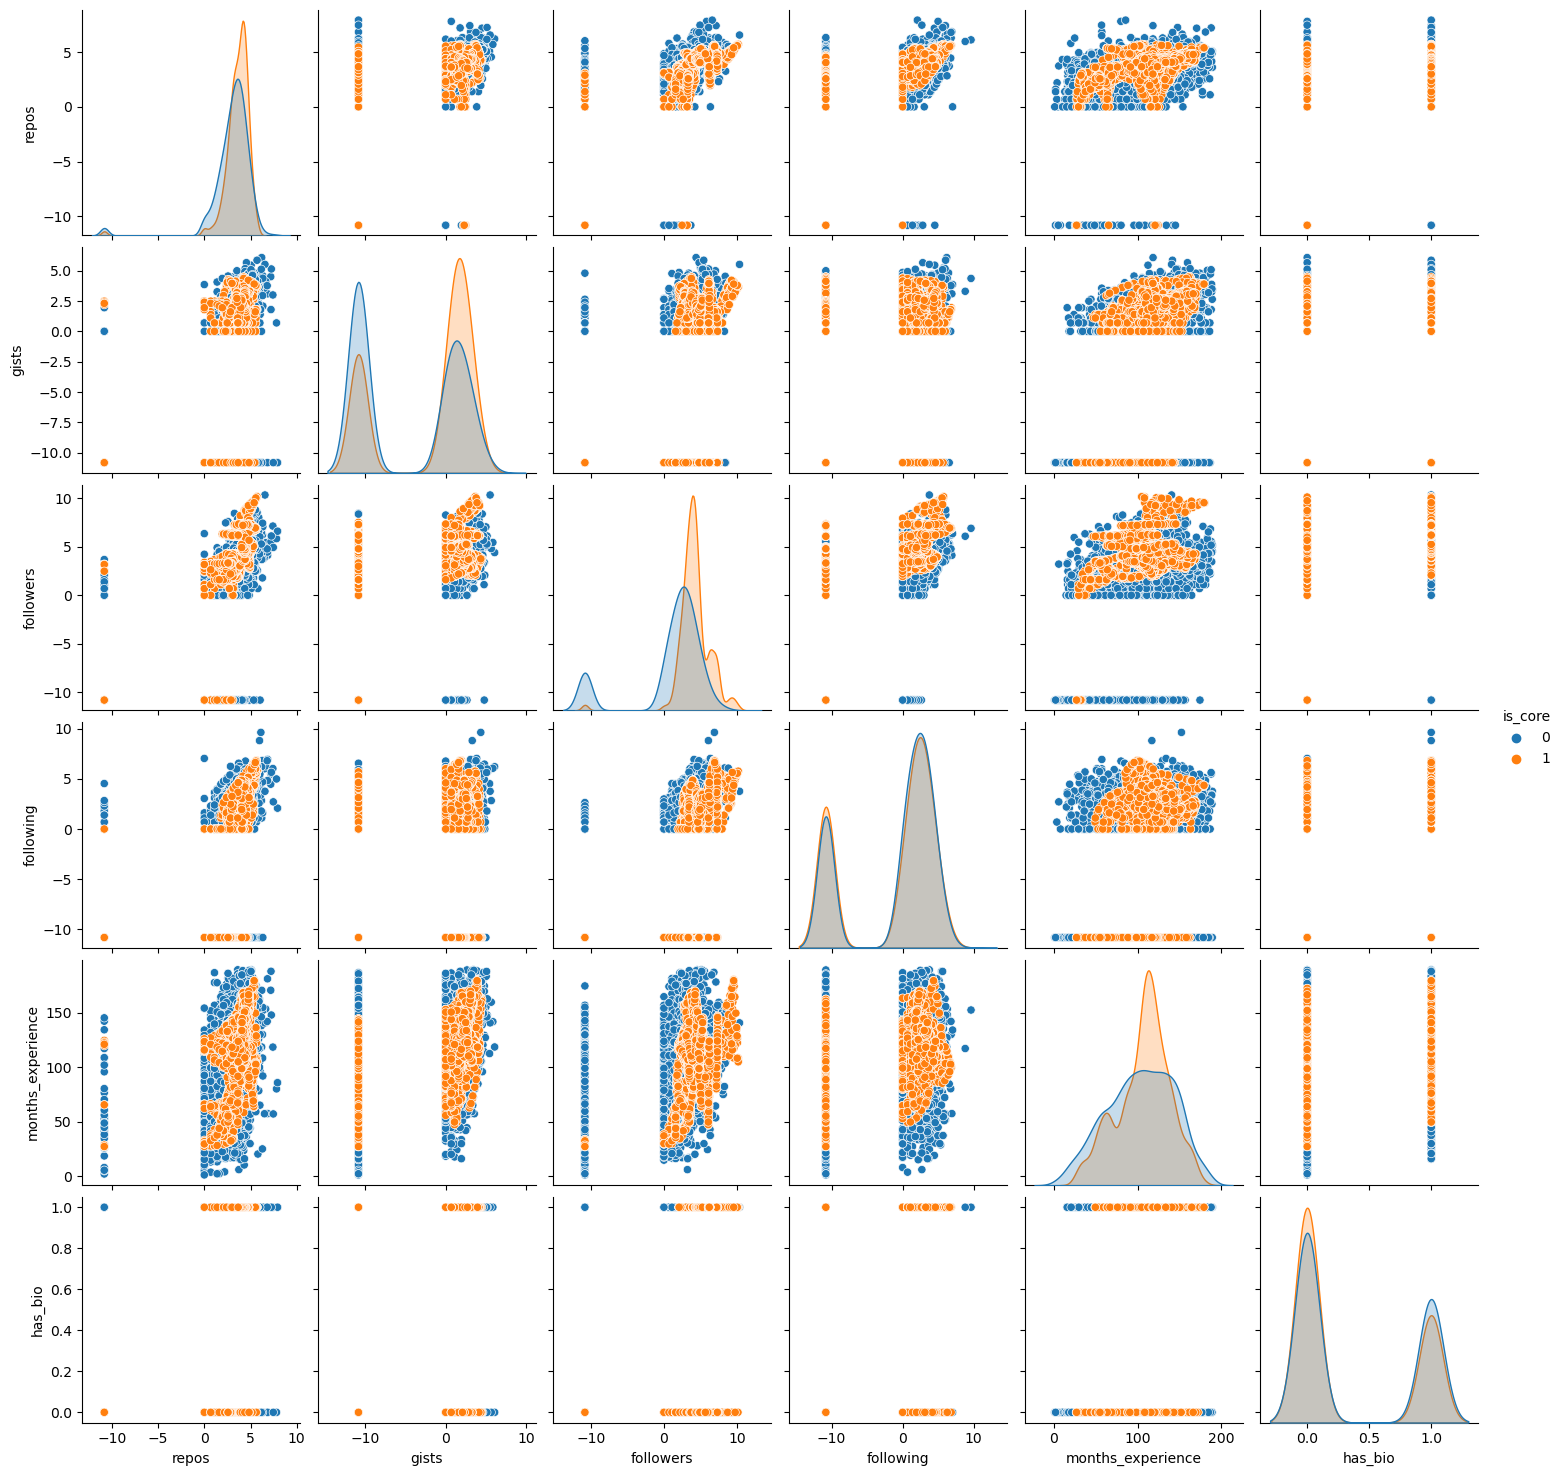

In [21]:
sns.pairplot(c3_train_log, hue = 'is_core')

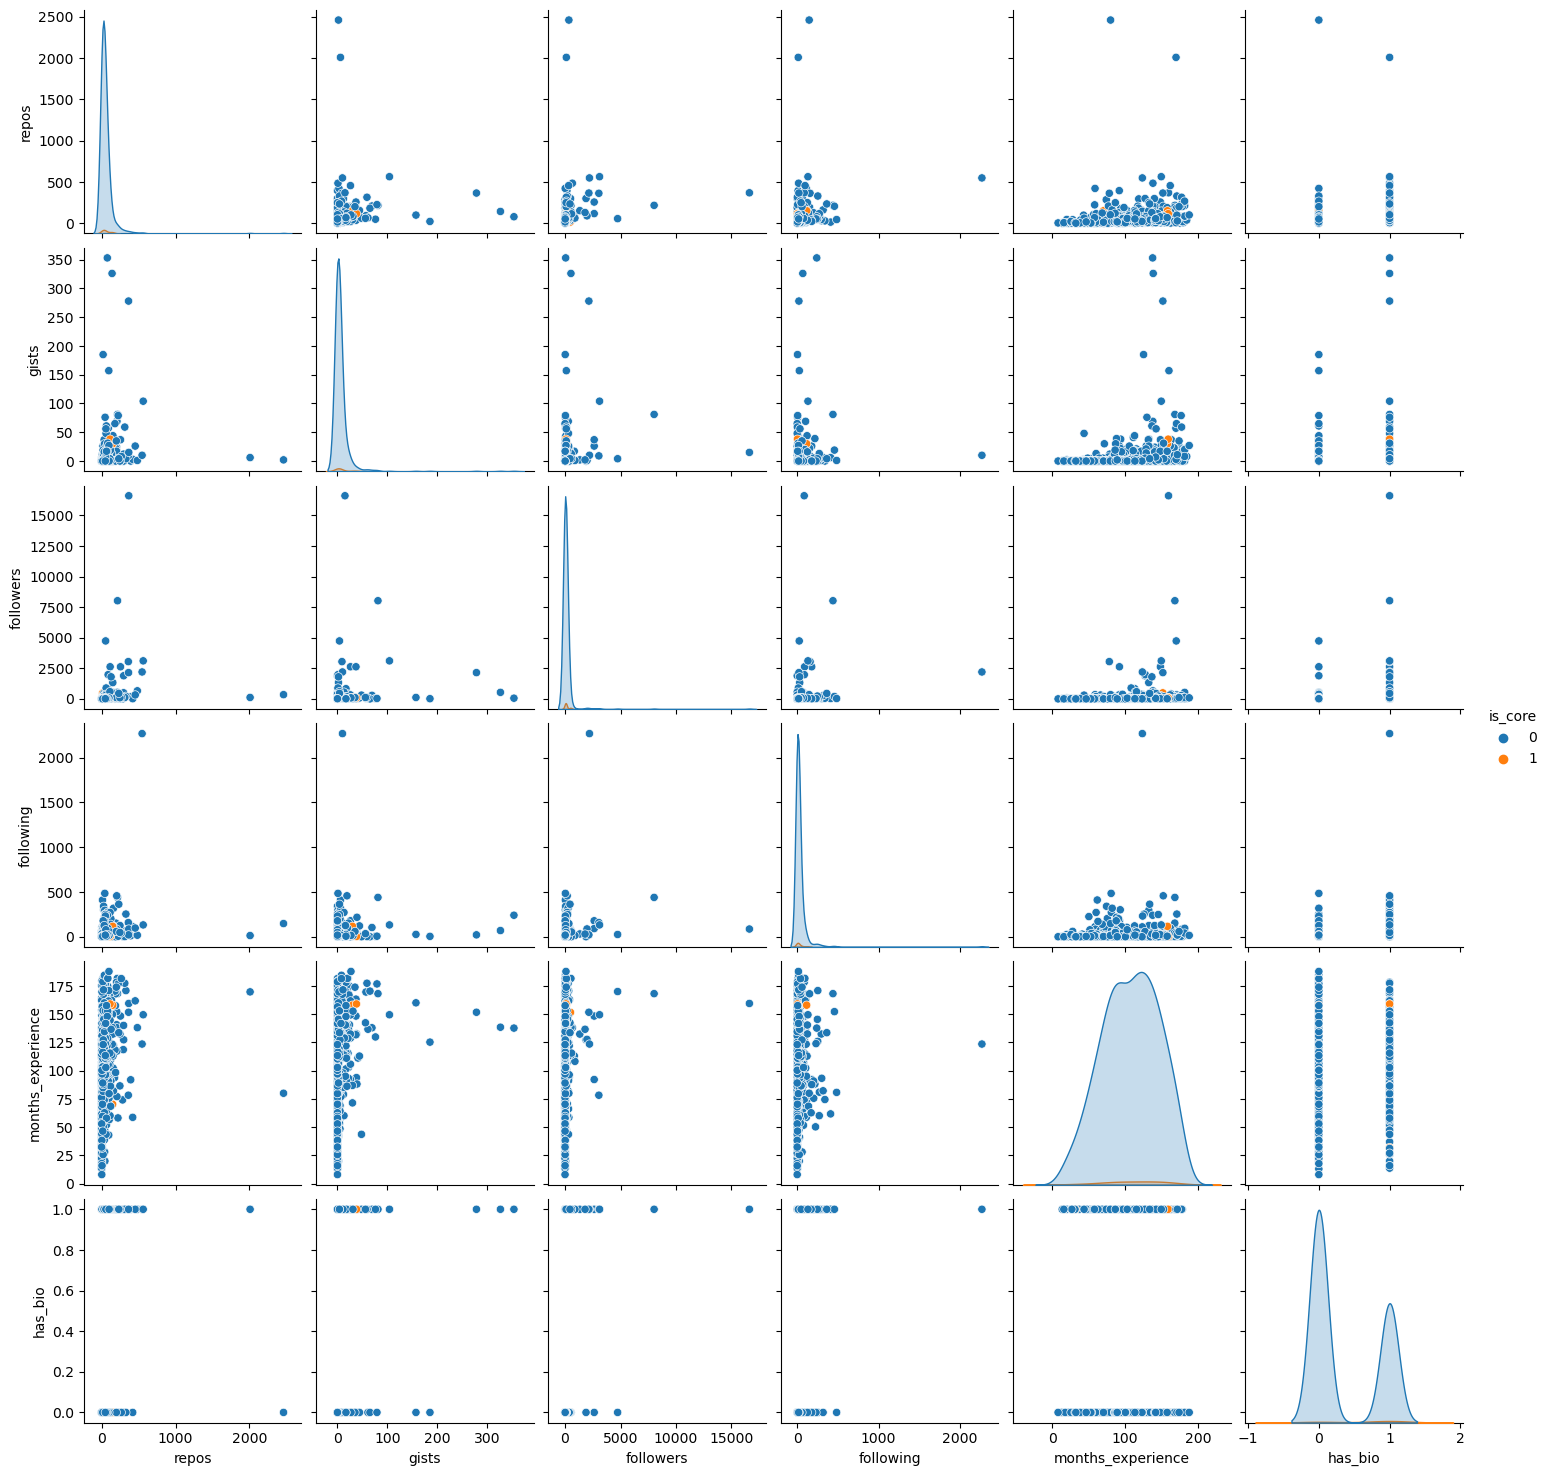

In [22]:
sns.pairplot(test_df, hue = 'is_core')

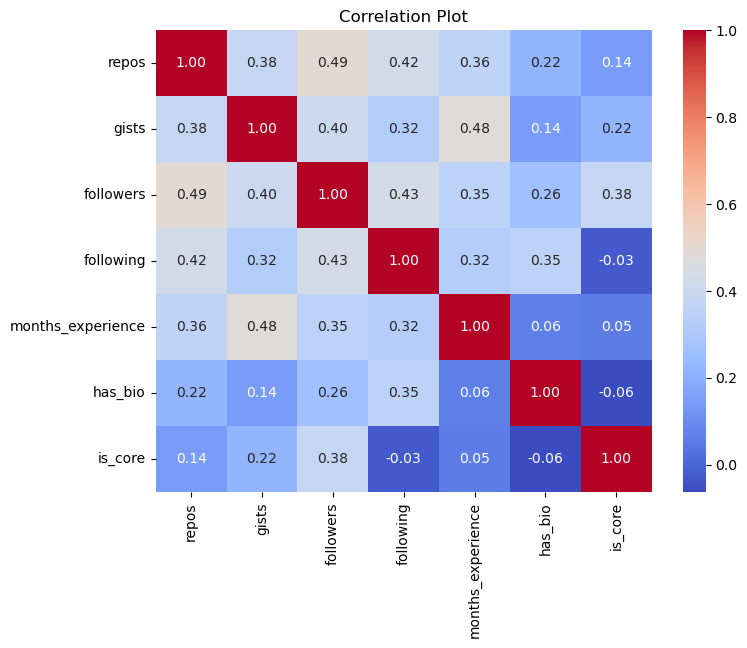

In [23]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c3_train_log.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

In [24]:
X = c3_train_log.drop('is_core', axis=1)
y = c3_train_log['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0381
gists: 0.0450
followers: 0.1618
following: 0.0122
months_experience: 0.0571
has_bio: 0.0000


In [25]:
X = c3_train.drop('is_core', axis=1)
y = c3_train['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0366
gists: 0.0332
followers: 0.1580
following: 0.0004
months_experience: 0.0570
has_bio: 0.0112


In [26]:
#scaler = StandardScaler()
#x = scaler.fit_transform(x)
#c3_adasyn_log_scaled = pd.DataFrame(x, columns=['repos', 'gists', 'followers', 'following', 'months_experience'])
#c3_adasyn_log_scaled = pd.concat([c3_adasyn_log_scaled, x2], axis = 1)
#c3_adasyn_log_scaled